# ojective:

### Build a model of housing prices in california using the californian census data

In [1]:
#import the standard libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.utils import check_array
from scipy import sparse
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

In [2]:
#loading the dataset
HOUSING_PATH = "/cxldata/datasets/project/housing"

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# features are :
#### median_age, median_house_value,median_income,ocean_proximity etc

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


total_bedrooms has 'null' values in it

In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


housing_median_age	

1st quartile - <=18
2nd quartile - <= 37
3rd quartile - <=52

##  EDA

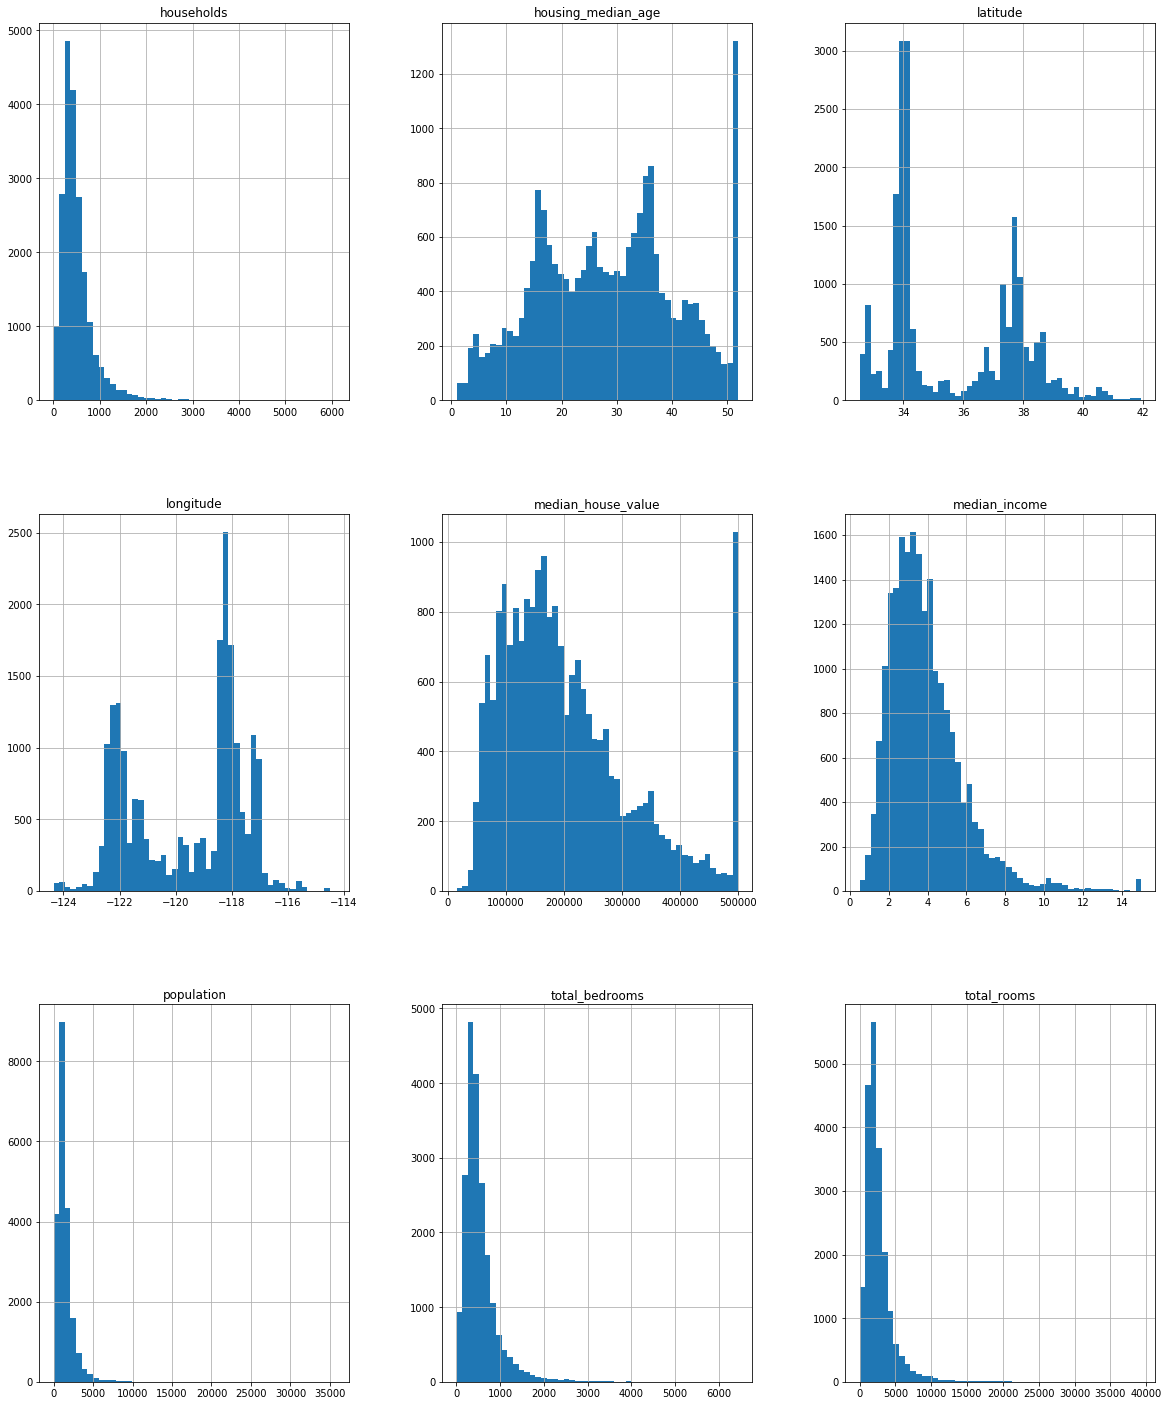

In [7]:
housing.hist(bins=50,figsize=(20,25))
plt.show()

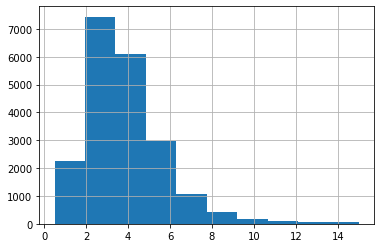

In [8]:
housing['median_income'].hist()
plt.show()

$2000-$5000 are major in the above graph and all the other minor median income is ignored

In [9]:
#creating a train-test split (user defined function)

In [10]:
def split_train_test(data,test_ratio):
    shuffuled_indices = np.random.permutation(len(data))
    
    test_set_size = int(len(data)*test_ratio)
    
    test_indices = shuffuled_indices[:test_set_size]
    train_indices = shuffuled_indices[test_set_size:]
    
    return data.iloc[train_indices],data.iloc[test_indices]

In [11]:
#seed is used to produce the same data when the function is run multiple times
np.random.seed(42)
train_set,test_set = split_train_test(housing,0.2)

In [12]:
#create unique and immutable identifier and detect to select if 
#the data has to go on training or testing data split

In [13]:
def test_set_check(identifier,test_ratio,hash):
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio

def split_train_test_by_id(data,test_ratio,id_column,hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_,test_ratio,hash))
    return data.loc[-in_test_set],data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index()
train_set,test_set= split_train_test_by_id(housing_with_id,0.2,"index")

In [15]:
#train test split using sklearn

In [16]:
train_set,test_set = train_test_split(housing, test_size=0.2, 
                                                    random_state=42)

In [17]:
#shirnk the income categories to avoid more statas

In [18]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [19]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat'] < 5,5.0,inplace=True)

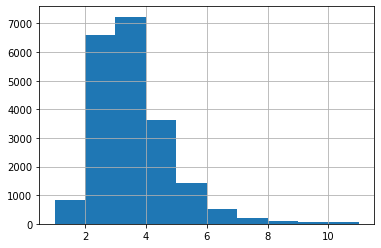

In [20]:
(np.ceil(housing['median_income']/1.5)).hist()
plt.show()

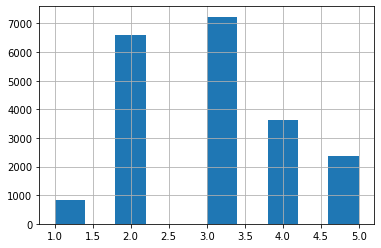

In [21]:
housing['income_cat'].hist()
plt.show()

In [22]:
#stratified sampling train test split

#it is to split the data bases on homogeneous strata(income_cat) 
#and selecting the instances carefully to fully represent the whole data

In [23]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,
                              random_state=42)
for train_index,test_index in split.split(housing,housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [24]:
#income category proportion in stratified test

In [25]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [26]:
#comparing the income category proportion in stratified and random sampling

In [27]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts()/len(data)

In [28]:
train_set,test_set = train_test_split(housing, test_size=0.2, 
                                                    random_state=42)

In [29]:
compare_props = pd.DataFrame({
    'overall':income_cat_proportions(housing),
    'stratified':income_cat_proportions(strat_test_set),
    'random':income_cat_proportions(test_set)
}).sort_index()

compare_props['rand % error'] = 100*compare_props['random']/compare_props['overall'] - 100
compare_props['strat % error'] = 100*compare_props['stratified']/compare_props['overall'] - 100

In [30]:
compare_props

,overall,stratified,random,rand % error,strat % error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


In [31]:
#drop the 'income_cat' columns
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

In [32]:
housing = strat_train_set.copy()

# EDA - 2

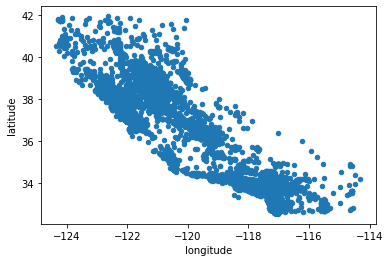

In [33]:
housing.plot(kind='scatter',x='longitude',y='latitude')
plt.show()

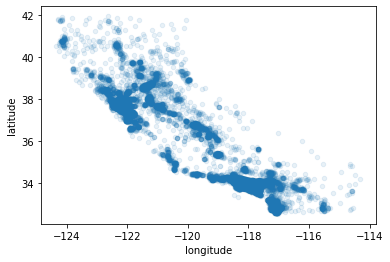

In [34]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)
plt.show()

population with high density is more dark when opacity is increased

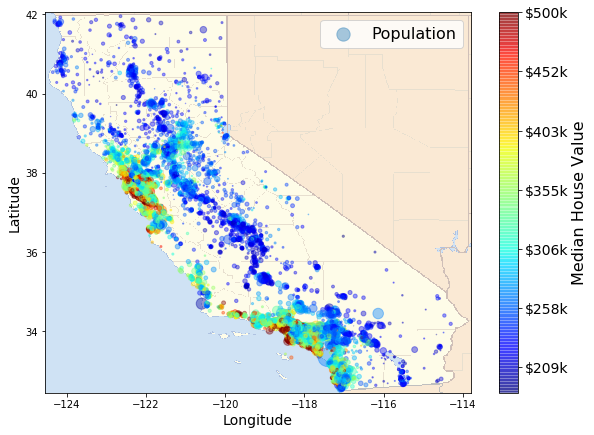

In [35]:
import matplotlib.image as mpimg
california_img=mpimg.imread('/cxldata/datasets/project/housing/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

the prices increase in coastal region

In [36]:
attrs = ['median_house_value','median_income','total_rooms','housing_median_age']

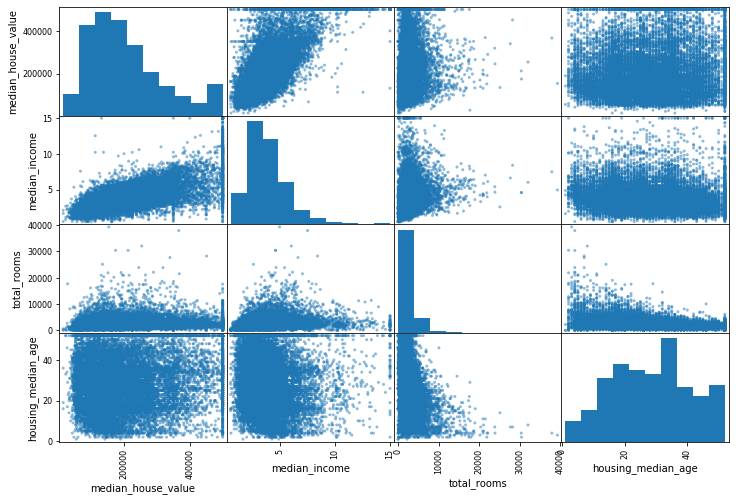

In [37]:
scatter_matrix(housing[attrs],figsize=(12,8))
plt.show()

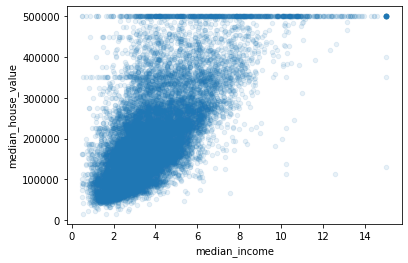

In [38]:
housing.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.1)
plt.show()

<li> as the median income increases medain house value also increases</li>
<li> there is a price cap for >500000 </li>

In [39]:
## build the correlation matrix

In [40]:
corr_mat = housing.corr()
corr_mat

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [41]:
corr_mat["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

median_house_value is correlated to <b> median_income </b>, <b> total_rooms </b>, <b> housing_median_age </b>

## adding or combining the different columns - feature engineering

In [42]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['population_per_household'] = housing['population']/housing['households']
housing['bedrooms_per_household'] = housing['total_bedrooms']/housing['total_rooms']

In [43]:
corr_mat1 = housing.corr()
corr_mat1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_per_household,bedrooms_per_household
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,-0.028345,-0.000410,0.095603
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,0.107621,0.005420,-0.116884
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.147186,0.015031,0.136788
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.127519,-0.024810,-0.192606
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.000377,-0.028370,0.086960
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,-0.074692,0.076225,0.037778
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,-0.083009,-0.027416,0.067162
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,0.311563,0.021822,-0.624674
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,0.146285,-0.021985,-0.259984
rooms_per_household,-0.028345,0.107621,-0.147186,0.127519,0.000377,-0.074692,-0.083009,0.311563,0.146285,1.000000,-0.005314,-0.398546


In [44]:
corr_mat1["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_household     -0.259984
Name: median_house_value, dtype: float64

median_house_value is correlated with <b>median_income</b> ,<b>rooms_per_household</b>, <b>total_rooms</b>, <b>housing_median_age</b>, <b>bedrooms_per_household</b>

## machine learning models

In [45]:
#split the stratified data into dependent and independent features
housing_labels = strat_train_set['median_house_value'].copy()
housing = strat_train_set.drop("median_house_value",axis=1)

In [46]:
#check for the nulls and strategize to fill the nulls into something 
#meaningful(mean/median/0) or drop the rows
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

## data cleaning

In [47]:
housing_incomplete = housing[housing.isnull().any(axis=1)].head()
housing_incomplete

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [48]:
#replace 'NaN' with median of 'total_bedroom' features
median = housing['total_bedrooms'].median()
housing_incomplete['total_bedrooms'].fillna(median,inplace=True)
housing_incomplete

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [49]:
#imputing the 'NaN' values of 'total_bedrooms'

In [50]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity',axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [51]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [52]:
X = imputer.transform(housing_num)

In [53]:
housing_tr = pd.DataFrame(X,columns=housing_num.columns)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


In [54]:
#convert the categorical columns into numerical(binary) - one hot encoding

In [55]:
housing_cat_encoded,housing_cats = housing['ocean_proximity'].factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [56]:
# encoder = OneHotEncoder()
# housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
# housing_cat_1hot.toarray()

# #used to convert single column to multiple vectors

In [57]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown
    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")
            
        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self
    
    
    
    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)
        
        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [58]:
cat_encoder = CategoricalEncoder(encoding='onehot-dense')
housing_cat_reshaped = housing_cats.values.reshape(-1,1)
housing_cat_1_hot = cat_encoder.fit_transform(housing_cat_reshaped)

housing_cat_1_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [59]:
#adding extra columns - feature engineering

In [60]:
# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [61]:
#helps sklearn to select the specfic columns from dataframe

In [62]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

### create a pipelines 
used instead of manual execution of code - cell by cell

In [63]:
num_attrs = list(housing_num)

cat_atts = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attrs)),
    ('imputer',SimpleImputer(strategy='median')),
    ('attrs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_atts)),
    ('cat_encoder',CategoricalEncoder(encoding='onehot-dense'))
])

In [64]:
#union both the pipeline and create a full pipeline

In [65]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline)
])

In [66]:
#create the transformed dataset

In [67]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Create ML Models

In [68]:
#linear regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
#mean squared error
housing_preds = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

model underfitting by linear regression

In [70]:
#decision tree
decs_tree_reg = DecisionTreeRegressor()
decs_tree_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [71]:
#mean squared error
housing_preds_dt = decs_tree_reg.predict(housing_prepared)
dtree_mse = mean_squared_error(housing_labels,housing_preds_dt)
dtree_rmse = np.sqrt(dtree_mse)
dtree_rmse

0.0

overfitting since rmse is 0.0

In [72]:
#Random Forest
rf_reg = RandomForestRegressor()
rf_reg.fit(housing_prepared,housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [73]:
#mean squared error
housing_preds_rf = rf_reg.predict(housing_prepared)
rf_mse = mean_squared_error(housing_labels,housing_preds_rf)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

18709.12470422179

In [74]:
#cross validation

In [75]:
#linear reg - cv
scores_lr = cross_val_score(lin_reg,housing_prepared,housing_labels,
                        scoring='neg_mean_squared_error',cv=10)
lr_rmse_scores = np.sqrt(-scores_lr)

In [76]:
#decision tree - cv
scores = cross_val_score(decs_tree_reg,housing_prepared,housing_labels,
                        scoring='neg_mean_squared_error',cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([68889.52377094, 66608.85839461, 69870.50199982, 69668.47885531,
       70927.533594  , 75887.19461571, 71289.7339394 , 71336.23644972,
       77303.61718002, 70152.48634542])

In [77]:
#random forest - cv
scores_rf = cross_val_score(rf_reg,housing_prepared,housing_labels,
                        scoring='neg_mean_squared_error',cv=10)
rf_rmse_scores = np.sqrt(-scores_rf)
rf_rmse_scores

array([49557.6095063 , 47584.54435547, 49605.349788  , 52325.13724488,
       49586.9889247 , 53154.87424699, 48800.48987508, 47880.32844243,
       52958.68645964, 50046.17489414])

In [78]:
def display_scores(scores):
    print("scores:",scores)
    print("mean:",scores.mean())
    print("std:",scores.std())

In [79]:
display_scores(lr_rmse_scores)

scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean: 69052.46136345083
std: 2731.674001798348


In [80]:
display_scores(tree_rmse_scores)

scores: [68889.52377094 66608.85839461 69870.50199982 69668.47885531
 70927.533594   75887.19461571 71289.7339394  71336.23644972
 77303.61718002 70152.48634542]
mean: 71193.41651449492
std: 3015.818986062509


In [81]:
display_scores(rf_rmse_scores)

scores: [49557.6095063  47584.54435547 49605.349788   52325.13724488
 49586.9889247  53154.87424699 48800.48987508 47880.32844243
 52958.68645964 50046.17489414]
mean: 50150.018373763225
std: 1902.0697041387534


Random forest performs better

## Fine-Tuning the model

In [82]:
#grid search

In [83]:
param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]

In [84]:
for_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(for_reg,param_grid=param_grid,cv=5,
                          scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [85]:
#check the best params to fit random forest regressor
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [86]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [87]:
#look at each hyperparameter scores

In [88]:
cves = grid_search.cv_results_
for mean_score,params in zip(cves['mean_test_score'],cves['params']):
    print(params,",",np.sqrt(-mean_score))

{'max_features': 2, 'n_estimators': 3} , 63669.11631261028
{'max_features': 2, 'n_estimators': 10} , 55627.099719926795
{'max_features': 2, 'n_estimators': 30} , 53384.57275149205
{'max_features': 4, 'n_estimators': 3} , 60965.950449450494
{'max_features': 4, 'n_estimators': 10} , 52741.04704299915
{'max_features': 4, 'n_estimators': 30} , 50377.40461678399
{'max_features': 6, 'n_estimators': 3} , 58663.93866579625
{'max_features': 6, 'n_estimators': 10} , 52006.19873526564
{'max_features': 6, 'n_estimators': 30} , 50146.51167415009
{'max_features': 8, 'n_estimators': 3} , 57869.25276169646
{'max_features': 8, 'n_estimators': 10} , 51711.127883959234
{'max_features': 8, 'n_estimators': 30} , 49682.273345071546
{'bootstrap': False, 'max_features': 2, 'n_estimators': 3} , 62895.06951262424
{'bootstrap': False, 'max_features': 2, 'n_estimators': 10} , 54658.176157539405
{'bootstrap': False, 'max_features': 3, 'n_estimators': 3} , 59470.40652318466
{'bootstrap': False, 'max_features': 3, '

In [89]:
#randomized search

In [90]:
param_dict = {
    'n_estimators':randint(low=1,high=200),
    'max_features':randint(low=1,high=8)
}

for_reg1 = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(for_reg1,param_distributions=param_dict,
                               n_iter=10,cv=5,
                                scoring='neg_mean_squared_error',
                               random_state=42)

rnd_search.fit(housing_prepared,housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [92]:
housing_extra_attribs.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'population_per_household'],
      dtype='object')

In [ ]:
#feature importances

In [93]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attrs = ['rooms_per_household', 'population_per_household','bedrooms_per_room']
cat_encoder = cat_pipeline.named_steps['cat_encoder']

cat_one_hot_attrs = list(cat_encoder.categories_[0])
attributes = num_attrs + extra_attrs + cat_one_hot_attrs

sorted(zip(feature_importances,attributes),reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'population_per_household'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_household'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

median_income,INLAND,population_per_household,longitude have greater feature 
importance scores

## evaluate the model on test set

In [94]:
final_model = grid_search.best_estimator_

In [95]:
#get x_test and y_test data
y_test = strat_test_set['median_house_value'].copy()
X_test = strat_test_set.drop("median_house_value",axis=1)

In [96]:
X_test_prepared = full_pipeline.transform(X_test)

In [97]:
final_preds = final_model.predict(X_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test,final_preds))
final_rmse

47730.22690385927

its not very bad as we have similar score on training data